# CSCI-UA 473 : Intro to Machine Learning - Final Project

## Device Information

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Dec 14 23:19:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    55W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Initial Setup

In [ ]:
# Remove Colab sample data
!rm -rf sample_data/

# Kaggle API credentials
%env KAGGLE_USERNAME=<KAGGLE_USERNAME>
%env KAGGLE_KEY=<KAGGLE_KEY>

## Download Dataset

In [5]:
# Download train and test sets
!kaggle competitions download -c csci-ua-473-intro-to-machine-learning-fall22

csci-ua-473-intro-to-machine-learning-fall22.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Unzip data
!unzip -n /content/csci-ua-473-intro-to-machine-learning-fall22.zip

Archive:  /content/csci-ua-473-intro-to-machine-learning-fall22.zip


## Import Packages

In [7]:
import os
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

## Load Data

In [8]:
# Load train set
train_X = torch.load("train/train/trainX.pt")
train_Y = torch.load("train/train/trainY.pt")

# Load test set
test_X = torch.load("test/test/testX.pt")

In [9]:
# Split train set into train/val set
train_size = len(train_X[2])
val_start_idx = int(train_size * 0.7)

val_X = [train_X[0][val_start_idx:, :, :, :, :],
         train_X[1][val_start_idx:, :, :, :],
         train_X[2][val_start_idx:]]

val_Y = [train_Y[0][val_start_idx:, :]]

train_X = [train_X[0][:val_start_idx, :, :, :, :],
           train_X[1][:val_start_idx, :, :, :],
           train_X[2][:val_start_idx]]

train_Y = [train_Y[0][:val_start_idx, :]]

In [27]:
# Profile train/test data
print("----- Total Train Size:", train_size, "-----\n")

print("Length of train_X:", len(train_X))
print("Shape of train_X rgb_images:", train_X[0].shape)
print("Shape of train_X depth_images:", train_X[1].shape)
print("Length of train_X file_ids:", len(train_X[2]), "\n")

print("Shape of train_Y:", train_Y[0].shape, "\n")

print("Length of val_X:", len(val_X))
print("Shape of val_X rgb_images:", val_X[0].shape)
print("Shape of val_X depth_images:", val_X[1].shape)
print("Length of val_X file_ids:", len(val_X[2]), "\n")

print("Shape of val_Y:", val_Y[0].shape, "\n")

print("----- Total Test Size:", len(test_X[2]), "-----\n")

print("Length of test_X:", len(test_X))
print("Shape of test_X rgb_images:", test_X[0].shape)
print("Shape of test_X depth_images:", test_X[1].shape)
print("Length of test_X file_ids:", len(test_X[2]))

----- Total Train Size: 3396 -----

Length of train_X: 3
Shape of train_X rgb_images: torch.Size([2377, 3, 3, 224, 224])
Shape of train_X depth_images: torch.Size([2377, 3, 224, 224])
Length of train_X file_ids: 2377 

Shape of train_Y: torch.Size([2377, 12]) 

Length of val_X: 3
Shape of val_X rgb_images: torch.Size([1019, 3, 3, 224, 224])
Shape of val_X depth_images: torch.Size([1019, 3, 224, 224])
Length of val_X file_ids: 1019 

Shape of val_Y: torch.Size([1019, 12]) 

----- Total Test Size: 849 -----

Length of test_X: 3
Shape of test_X rgb_images: torch.Size([849, 3, 3, 224, 224])
Shape of test_X depth_images: torch.Size([849, 3, 224, 224])
Length of test_X file_ids: 849


## Creating a Custom Dataset

In [29]:
class RobotHandDataset(Dataset):
    def __init__(self, X, Y=None, view='top', rgb_transform=None, depth_transform=None, target_transform=None):
        self.rgb_images = X[0]
        self.depth_images = X[1]
        self.file_ids = X[2]

        if view == 'top':
            self.view = 0
        elif view == 'left':
            self.view = 1
        else:
            self.view = 2

        self.robot_states = self.robot_states = Y[0] if Y != None else None

        self.rgb_transform = rgb_transform
        self.target_transform = target_transform
        self.depth_transform = depth_transform

    def __len__(self):
        return self.rgb_images.shape[0]

    def __getitem__(self, idx):
        rgb_image = self.rgb_images[idx][self.view]
        depth_image = self.depth_images[idx][self.view]

        if self.robot_states != None:
            state = self.robot_states[idx]
        
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)
        
        if self.rgb_transform:
            rgb_image = self.rgb_transform(x=rgb_image, depth_image=depth_image)

        if self.robot_states != None and self.target_transform:
            label = self.target_transform(label)
        
        rgbd_image = torch.cat((rgb_image, depth_image), 0)

        # rgbd_image = rgbd_image.permute(1, 2, 0)

        return rgbd_image.float(), state.float()

## Initialize Dataset and DataLoader

In [30]:
# # Calculate normalization metrics
VIEW = 0

mean_r = np.array(train_X[0][:, VIEW, 0, :, :].flatten() / 255).mean()
mean_g = np.array(train_X[0][:, VIEW, 1, :, :].flatten() / 255).mean()
mean_b = np.array(train_X[0][:, VIEW, 2, :, :].flatten() / 255).mean()

std_r = np.array(train_X[0][:, VIEW, 0, :, :].flatten() / 255).std()
std_g = np.array(train_X[0][:, VIEW, 1, :, :].flatten() / 255).std()
std_b = np.array(train_X[0][:, VIEW, 2, :, :].flatten() / 255).std()

mean_depth = np.array(train_X[1][:, VIEW, :, :].flatten() / 1000).mean()
std_depth = np.array(train_X[1][:, VIEW, :, :].flatten() / 1000).std()

In [31]:
def rgb_transform(x, depth_image):
    q50, q37, q25 = np.percentile(depth_image[0].flatten(), [50, 37.5, 25])

    indices = np.where(depth_image[0] > q37)
    x[0, :, :][indices] = 0
    x[1, :, :][indices] = 0
    x[2, :, :][indices] = 0

    cube_threshold = 80.0
    indices = np.where(x[0, :, :] < cube_threshold)
    x[0, :, :][indices] = 0
    x[1, :, :][indices] = 0
    x[2, :, :][indices] = 0

    indices = np.where(x[1, :, :] < cube_threshold)
    x[0, :, :][indices] = 0
    x[1, :, :][indices] = 0
    x[2, :, :][indices] = 0

    indices = np.where(x[2, :, :] < cube_threshold)
    x[0, :, :][indices] = 0
    x[1, :, :][indices] = 0
    x[2, :, :][indices] = 0

    table_threshold = 170.0
    indices1 = np.where(x[0, :, :] < table_threshold, True, False)
    indices2 = np.where(x[1, :, :] < table_threshold, True, False)
    indices3 = np.where(x[2, :, :] < table_threshold, True, False)
    
    indices = np.all([indices1, indices2, indices3], axis=0)
    
    x[0, :, :][indices] = 0
    x[1, :, :][indices] = 0
    x[2, :, :][indices] = 0

    x = x / 255.0
    
    # x = transforms.Normalize([mean_r, mean_g, mean_b], [std_r, std_g, std_b]).forward(x)
    # x = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).forward(x)
    
    return x

def depth_transform(x):
    x = torch.tensor(np.expand_dims(x, 0))
    x = x / 1000.0
    x = transforms.Normalize([mean_depth], [std_depth]).forward(x)
    return x

datasets = {
    "train": RobotHandDataset(X=train_X, Y=train_Y, view='top',
                              rgb_transform=rgb_transform, depth_transform=depth_transform),
    "val": RobotHandDataset(X=val_X, Y=val_Y, view='top',
                            rgb_transform=rgb_transform, depth_transform=depth_transform),
    "test": RobotHandDataset(X=test_X, Y=val_Y, view='top',
                             rgb_transform=rgb_transform, depth_transform=depth_transform)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, shuffle=True, num_workers=2),
    'val': DataLoader(datasets['val'], batch_size=32, shuffle=True, num_workers=2),
    'test': DataLoader(datasets['test'], batch_size=1, shuffle=False, num_workers=2),
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current device:", device)

Current device: cuda:0


## Display Images

Image batch shape: torch.Size([4, 224, 224]) 

Labels batch shape: torch.Size([12]) 

State: 0.026672374457120895 



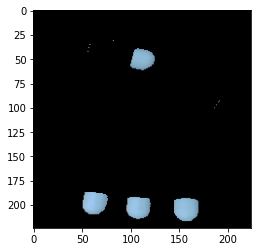

In [33]:
# Display image and label.
train_rgbd_images, train_states = datasets["train"].__getitem__(0)

print(f"Image batch shape: {train_rgbd_images.size()}", "\n")
print(f"Labels batch shape: {train_states.size()}", "\n")

print(f"State: {train_states[0]}", "\n")

img = train_rgbd_images[:3,:,:].permute(1, 2, 0).squeeze()
plt.imshow(img)
# plt.gcf().set_dpi(300)
plt.show()

## Transfer Learning

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, states in dataloaders[phase]:
                inputs = inputs.to(device)
                states = states.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = torch.sqrt(criterion(outputs, states))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train':
                scheduler.step()
                print(f"Current LR: {scheduler.get_last_lr()[0]:.8f}")

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.5f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss_unchange = 0
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'val':
                print(f"Best Loss: {best_loss:.5f}")

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val loss: {best_loss:.5f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
model = resnet50(weights="IMAGENET1K_V2")

# Change num input channels from 3 to 4
weight = model.conv1.weight.data.clone()

model.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    model.conv1.weight.data[:, :3] = weight
    model.conv1.weight.data[:, 3] = model.conv1.weight.data[:, 0]

num_ftrs = model.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, train_states.size(0))

model_ft = model.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

In [18]:
model_ft

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=300)

Epoch 1/300
----------
Current LR: 0.10000000
train Loss: 0.02554
val Loss: 0.01230
Best Loss: 0.01230

Epoch 2/300
----------
Current LR: 0.10000000
train Loss: 0.00996
val Loss: 0.01082
Best Loss: 0.01082

Epoch 3/300
----------
Current LR: 0.10000000
train Loss: 0.00851
val Loss: 0.00860
Best Loss: 0.00860

Epoch 4/300
----------
Current LR: 0.10000000
train Loss: 0.00740
val Loss: 0.00811
Best Loss: 0.00811

Epoch 5/300
----------
Current LR: 0.10000000
train Loss: 0.00716
val Loss: 0.00719
Best Loss: 0.00719

Epoch 6/300
----------
Current LR: 0.10000000
train Loss: 0.00616
val Loss: 0.00661
Best Loss: 0.00661

Epoch 7/300
----------
Current LR: 0.10000000
train Loss: 0.00622
val Loss: 0.00612
Best Loss: 0.00612

Epoch 8/300
----------
Current LR: 0.10000000
train Loss: 0.00578
val Loss: 0.00601
Best Loss: 0.00601

Epoch 9/300
----------
Current LR: 0.10000000
train Loss: 0.00591
val Loss: 0.00751
Best Loss: 0.00601

Epoch 10/300
----------
Current LR: 0.10000000
train Loss: 0.005

## Try Adding Dropout Layer

In [20]:
def adjust_model(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            setattr(model, child_name, nn.Sequential(
                child,
                nn.Dropout(p=0.1)
            ))
        else:
            adjust_model(child)

In [21]:
model_dropout = resnet50(weights="IMAGENET1K_V2")

# Change num input channels from 3 to 4
weight = model_dropout.conv1.weight.data.clone()

model_dropout.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    model_dropout.conv1.weight.data[:, :3] = weight
    model_dropout.conv1.weight.data[:, 3] = model_dropout.conv1.weight.data[:, 0]

num_ftrs_dropout = model_dropout.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_dropout.fc = nn.Linear(num_ftrs_dropout, train_states.size(0))

# Insert dropout layer after every BatchNorm2d layer
adjust_model(model_dropout)

model_dropout_ft = model_dropout.to(device)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_dropout.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

In [ ]:
model_dropout_ft

In [ ]:
model_dropout_ft = train_model(model_dropout_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

## Generate Output

In [22]:
!rm -rf submission.csv

In [23]:
outfile = 'submission.csv'

output_file = open(outfile, 'w')

titles = ['ID', 'FINGER_POS_1', 'FINGER_POS_2', 'FINGER_POS_3', 'FINGER_POS_4', 'FINGER_POS_5', 'FINGER_POS_6',
         'FINGER_POS_7', 'FINGER_POS_8', 'FINGER_POS_9', 'FINGER_POS_10', 'FINGER_POS_11', 'FINGER_POS_12']

preds = []

In [24]:
test_data = torch.load('test/test/testX.pt')
file_ids = test_data[-1]

model_ft.eval()

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    outputs = model(inputs)
    preds.append(outputs[0].cpu().detach().numpy())

In [25]:
df = pd.concat([pd.DataFrame(file_ids), pd.DataFrame.from_records(preds)], axis = 1, names = titles)
df.columns = titles
df.to_csv(outfile, index = False)
print("Written to csv file {}".format(outfile))

Written to csv file submission.csv


In [26]:
# !kaggle competitions submit -c csci-ua-473-intro-to-machine-learning-fall22 -f submission.csv -m "Training complete in 30m 15s; Best val loss: 0.00320"

100% 122k/122k [00:02<00:00, 56.2kB/s]
Successfully submitted to CSCI-UA. 473 Intro to Machine Learning, Fall 2022

---